NOTE: defining the HOME path constant

In [1]:
import os
HOME = os.getcwd()
print(f'HOME directory path: \'{HOME}\'')

HOME directory path: '/content'


### Important ! Add "requirements.txt" file to working directory

In [2]:
# Installing required packages
!pip install -r {HOME}/requirements.txt --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.7/898.7 kB 40.2 MB/s eta 0:00:00


### Connecting to Roboflow dataset

In [3]:
import roboflow
roboflow.login(force=True) # Login into roboflow

visit https://app.roboflow.com/auth-cli to get your authentication token.
Paste the authentication token here: ··········


In [5]:
# Downloading dataset from Roboflow platform (Notice: after execution data will be deleted from google colab)
dataset_name = 'hurricanedamagev7'
dataset_version = 2
model_name = 'yolo'
model_version = '11' # '8v' or '11'
model_variant = 'n' # parameter required for model training phase

# Connect to roboflow dataset
rf = roboflow.Roboflow()
project = rf.workspace('stormdamagechallenge').project(dataset_name + '-f6aoq')
dataset = project.version(dataset_version).download(model_name + model_version)

loading Roboflow workspace...
loading Roboflow project...
Exporting format yolov11 in progress : 85.0%
Version export complete for yolov11 format



Extracting Dataset Version Zip to hurricanedamagev7-2 in yolov11:: 100%|██████████| 11846/11846 [00:05<00:00, 2180.94it/s]


### Import remaining packages

In [6]:
import torch

# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# GeoTiff Images
import rasterio
from osgeo import gdal

# Visualisation
from matplotlib import pyplot as plt
import matplotlib.image as img
from matplotlib.pyplot import figure
from PIL import Image

# Model Building
import ultralytics
from ultralytics import YOLO
from IPython.display import Image

# Progress bar
from tqdm import tqdm

import numpy as np

# Others
import os
import shutil
import zipfile

%matplotlib inline

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


Check the version of Ultralytics

In [7]:
ultralytics.checks()

Ultralytics 8.3.49 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 33.0/112.6 GB disk)


In [8]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())

True
1


In [9]:
!nvidia-smi

Sat Dec 14 08:25:52 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8              12W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Loading YOLO model for Training


In [16]:
# Loading the model
model = YOLO(f'../models/{model_name + model_version}/{model_name + model_version + model_variant}.pt')
# Display model information (optional)
model.info()

100%|██████████| 5.35M/5.35M [00:00<00:00, 87.1MB/s]


YOLO11n summary: 319 layers, 2,624,080 parameters, 0 gradients, 6.6 GFLOPs


(319, 2624080, 0, 6.614336)

### Training Model

In [18]:
yaml_file = f'{HOME}/hurricanedamagev7-{dataset_version}/data.yaml'
yaml_file

'/content/hurricanedamagev7-2/data.yaml'

#### Resume model training from last step (optional)

In [ ]:
# Resuming model training from last completed epoch
# model = YOLO('last.pt')

In [35]:
# Define model training parameters
batch = -1 # set as an integer (e.g., batch=16), auto mode for 60% GPU memory utilization (batch=-1), or auto mode with specified utilization fraction (batch=0.70)
device = 0 # 0: GPU | 'cpu': cpu | 'mps': apple silicon mps
epochs = 20
patience = 5
imgsz = 512 # TODO: assess the importance of image size 640x640 by-design of Yolo models, image size role
plots = True
project = 'exploratory_phase' # parent directory name
name_train = f'{model_name + model_version + model_variant}_training_dataset_v{dataset_version}' # # run directory name

In [21]:
# Train the model
model.train(data=yaml_file, batch = batch, device = device, epochs = epochs, patience = patience, imgsz = imgsz, plots = plots, project = project, name = name_train)

Ultralytics 8.3.49 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=../models/yolo11/yolo11n.pt, data=/content/hurricanedamagev7-2/data.yaml, epochs=20, time=None, patience=5, batch=-1, imgsz=512, save=True, save_period=-1, cache=False, device=0, workers=8, project=exploratory_phase, name=continue_training_dataset_v2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, s

100%|██████████| 755k/755k [00:00<00:00, 21.3MB/s]


Overriding model.yaml nc=80 with nc=4

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 97.8MB/s]


AMP: checks passed ✅


train: Scanning /content/hurricanedamagev7-2/train/labels... 3555 images, 1 backgrounds, 0 corrupt: 100%|██████████| 3555/3555 [00:02<00:00, 1718.66it/s]

train: New cache created: /content/hurricanedamagev7-2/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
AutoBatch: Computing optimal batch size for imgsz=512 at 60.0% CUDA memory utilization.
AutoBatch: CUDA:0 (Tesla T4) 14.75G total, 0.10G reserved, 0.06G allocated, 14.59G free
      Params      GFLOPs  GPU_mem (GB)  forward (ms) backward (ms)                   input                  output
     2590620       4.124         0.189         67.96         393.8        (1, 3, 512, 512)                    list
     2590620       8.248         0.260         30.07         63.57        (2, 3, 512, 512)                    list
     2590620        16.5         0.457          32.2         62.15        (4, 3, 512, 512)                    list
     2590620       32.99         0.795         42.87         86.05        (8, 3, 512, 512)                    list
     2590620       65.98         1.

train: Scanning /content/hurricanedamagev7-2/train/labels.cache... 3555 images, 1 backgrounds, 0 corrupt: 100%|██████████| 3555/3555 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/hurricanedamagev7-2/valid/labels... 1181 images, 1 backgrounds, 0 corrupt: 100%|██████████| 1181/1181 [00:01<00:00, 624.35it/s]


val: New cache created: /content/hurricanedamagev7-2/valid/labels.cache
Plotting labels to exploratory_phase/continue_training_dataset_v2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.00125, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0007421875), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 512 train, 512 val
Using 2 dataloader workers
Logging results to exploratory_phase/continue_training_dataset_v2
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      11.3G      1.407      3.127        1.3        948        512: 100%|██████████| 38/38 [00:44<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:13<00:00,  1.98s/it]


                   all       1181      21053     0.0435      0.674       0.22      0.134

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      10.6G      1.118      1.514      1.113       1109        512: 100%|██████████| 38/38 [00:43<00:00,  1.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<00:00,  1.68s/it]


                   all       1181      21053      0.369      0.284       0.28      0.192

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      13.4G      1.039      1.254      1.092       1205        512: 100%|██████████| 38/38 [00:44<00:00,  1.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:10<00:00,  1.52s/it]


                   all       1181      21053      0.335      0.425      0.319      0.219

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      12.1G      1.019      1.196      1.086        849        512: 100%|██████████| 38/38 [00:46<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<00:00,  1.64s/it]


                   all       1181      21053      0.387      0.565      0.399      0.278

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20        13G     0.9844      1.129      1.066        945        512: 100%|██████████| 38/38 [00:42<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:13<00:00,  1.86s/it]


                   all       1181      21053       0.34      0.642      0.339      0.242

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      12.1G     0.9718      1.087      1.059       1045        512: 100%|██████████| 38/38 [00:42<00:00,  1.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:12<00:00,  1.84s/it]


                   all       1181      21053      0.526      0.603      0.565      0.412

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      12.4G     0.9479      1.071       1.05       1203        512: 100%|██████████| 38/38 [00:45<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:12<00:00,  1.77s/it]


                   all       1181      21053      0.485      0.614      0.544      0.396

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      13.1G     0.9482      1.068      1.053       1324        512: 100%|██████████| 38/38 [00:44<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<00:00,  1.58s/it]


                   all       1181      21053      0.499      0.597      0.528      0.391

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      15.5G      0.923       1.02      1.039       1183        512: 100%|██████████| 38/38 [00:43<00:00,  1.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<00:00,  1.63s/it]


                   all       1181      21053      0.525      0.592      0.574      0.415

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      13.4G     0.9168      1.009      1.034       1285        512: 100%|██████████| 38/38 [00:44<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:12<00:00,  1.76s/it]


                   all       1181      21053      0.543      0.616      0.591      0.443
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      10.4G     0.8706       1.02      1.026        497        512: 100%|██████████| 38/38 [00:45<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:12<00:00,  1.79s/it]


                   all       1181      21053      0.454      0.598      0.504      0.379

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      11.7G     0.8506     0.9695      1.019        654        512: 100%|██████████| 38/38 [00:39<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:12<00:00,  1.73s/it]


                   all       1181      21053      0.536      0.601      0.603      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      10.2G     0.8355     0.9399      1.009        928        512: 100%|██████████| 38/38 [00:39<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:14<00:00,  2.08s/it]


                   all       1181      21053      0.583      0.642      0.638      0.476

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      11.2G      0.832     0.9205      1.006        705        512: 100%|██████████| 38/38 [00:39<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:12<00:00,  1.77s/it]


                   all       1181      21053      0.535       0.62      0.593      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      10.9G     0.8234     0.9089      1.006        741        512: 100%|██████████| 38/38 [00:40<00:00,  1.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<00:00,  1.67s/it]


                   all       1181      21053      0.556      0.611      0.595      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      10.1G     0.8098     0.8948     0.9983        731        512: 100%|██████████| 38/38 [00:40<00:00,  1.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:12<00:00,  1.80s/it]

                   all       1181      21053      0.547      0.641      0.618      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      10.4G     0.8037     0.8857     0.9977        713        512: 100%|██████████| 38/38 [00:43<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:12<00:00,  1.82s/it]

                   all       1181      21053      0.586       0.66      0.665      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      10.7G     0.7879     0.8647     0.9906        769        512: 100%|██████████| 38/38 [00:40<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<00:00,  1.63s/it]

                   all       1181      21053       0.58      0.653      0.659      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      10.7G     0.7858      0.854     0.9866        794        512: 100%|██████████| 38/38 [00:40<00:00,  1.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:11<00:00,  1.66s/it]


                   all       1181      21053      0.609      0.661      0.681      0.532

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      9.64G      0.774     0.8355      0.981        528        512: 100%|██████████| 38/38 [00:39<00:00,  1.04s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:13<00:00,  1.95s/it]


                   all       1181      21053      0.615      0.661      0.673      0.528

20 epochs completed in 0.315 hours.
Optimizer stripped from exploratory_phase/continue_training_dataset_v2/weights/last.pt, 5.4MB
Optimizer stripped from exploratory_phase/continue_training_dataset_v2/weights/best.pt, 5.4MB

Validating exploratory_phase/continue_training_dataset_v2/weights/best.pt...
Ultralytics 8.3.49 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLO11n summary (fused): 238 layers, 2,582,932 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:31<00:00,  4.55s/it]


                   all       1181      21053      0.609      0.662      0.681      0.531
damagedcommercialbuilding        463        893      0.473      0.424      0.441      0.314
damagedresidentialbuilding        871       3503      0.578      0.662      0.668      0.509
undamagedcommercialbuilding        665       2449      0.602      0.651      0.684      0.542
undamagedresidentialbuilding        892      14208      0.783      0.911      0.932      0.761
Speed: 0.2ms preprocess, 1.8ms inference, 0.0ms loss, 4.0ms postprocess per image
Results saved to exploratory_phase/continue_training_dataset_v2


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x79244c0e19f0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0

/content


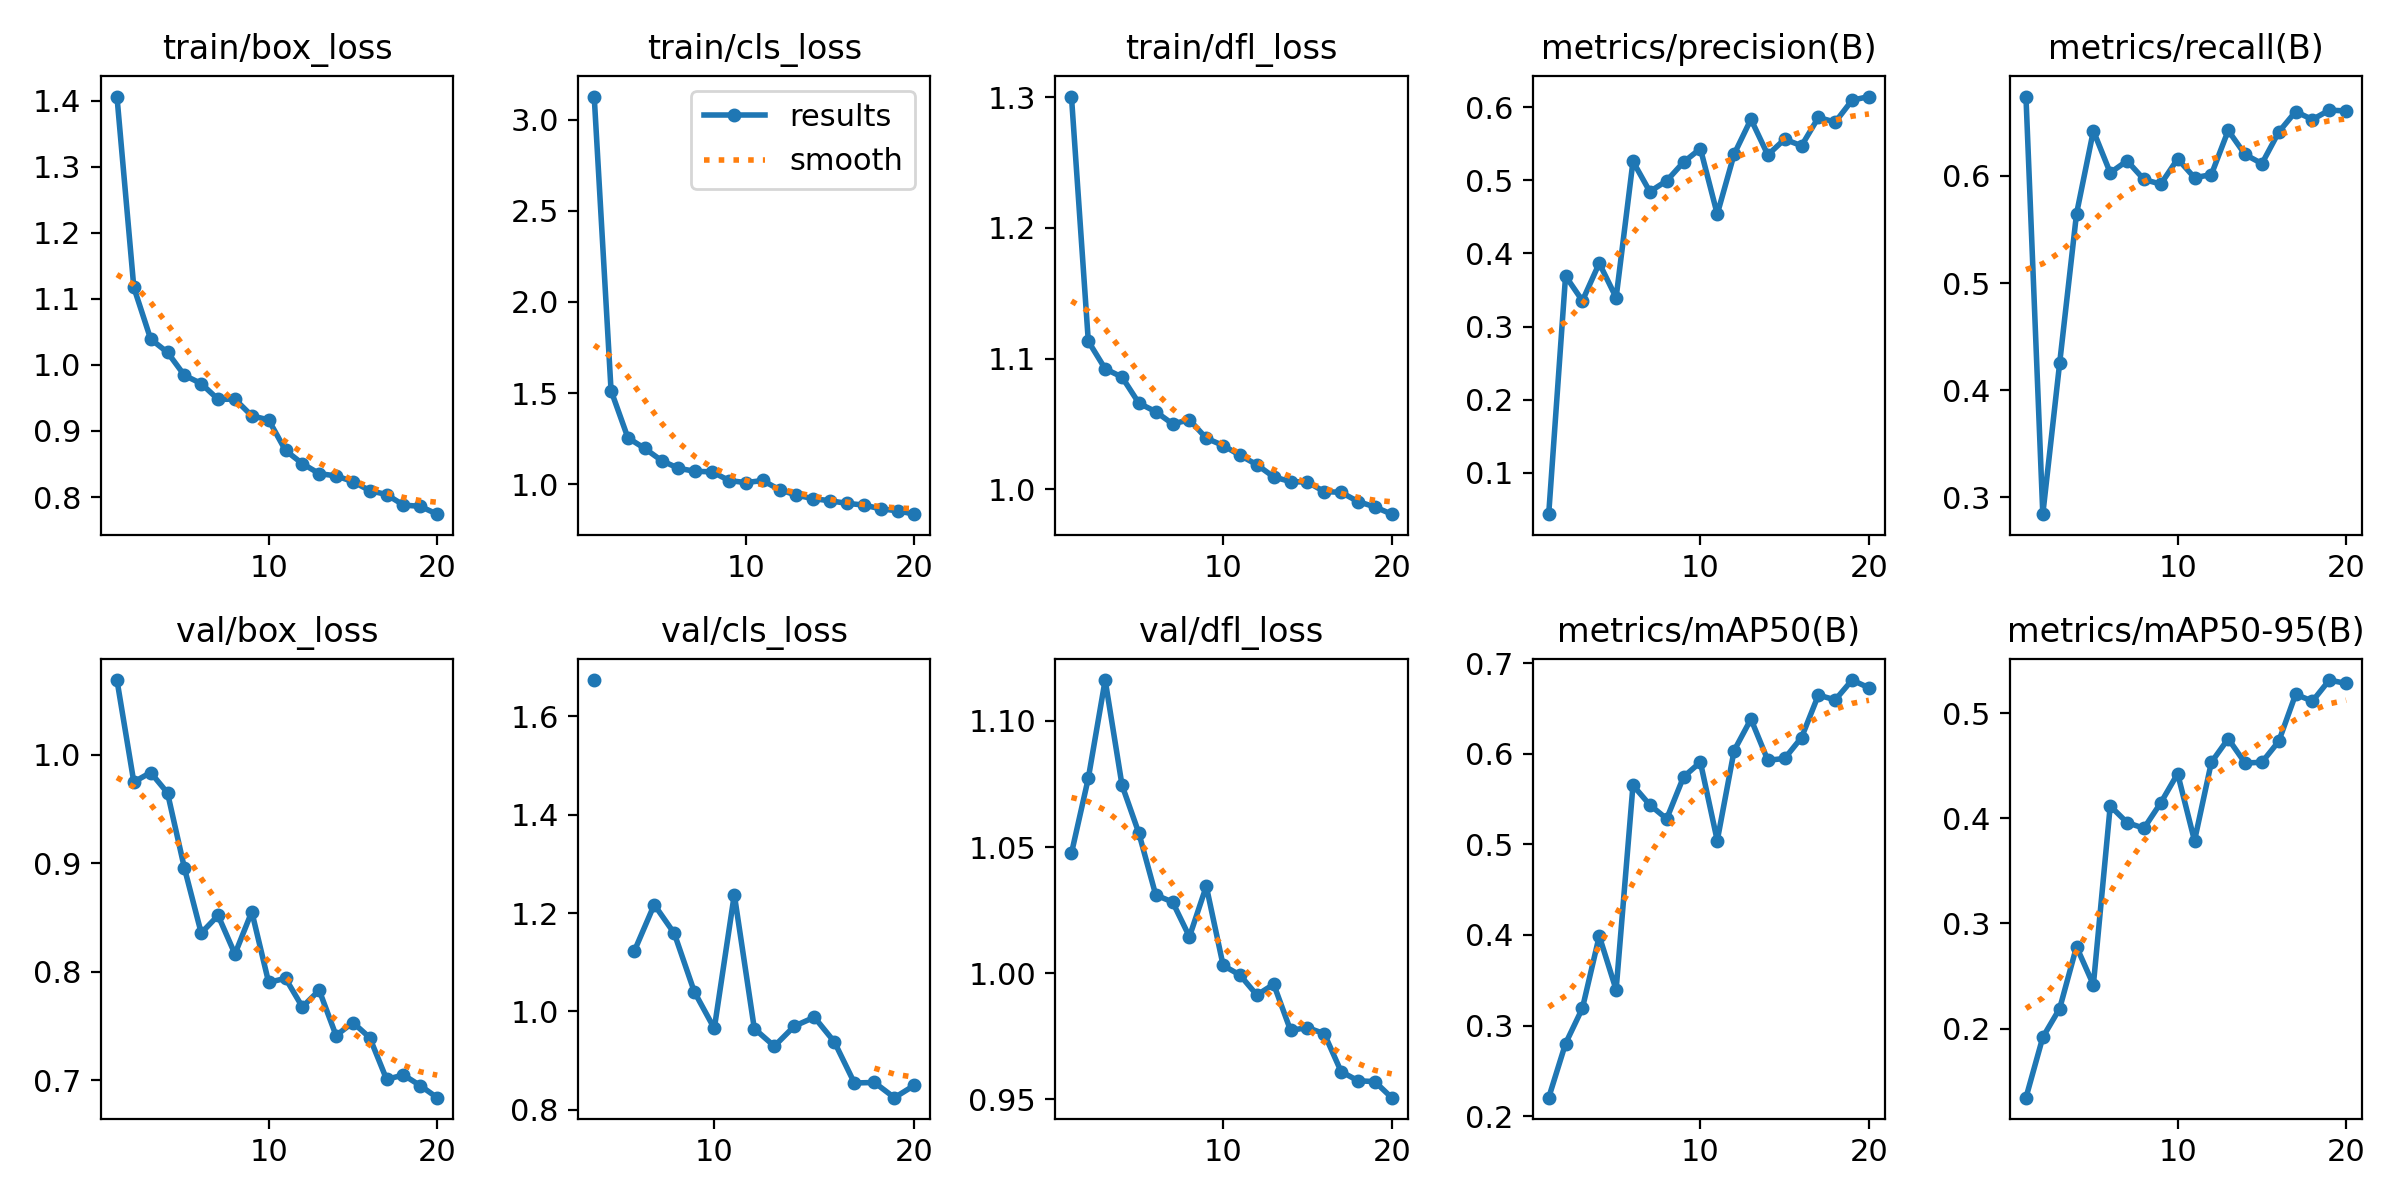

In [49]:
%cd {HOME}
Image(filename=f'{HOME}/{project}/{name_train}/results.png', width=600)

/content


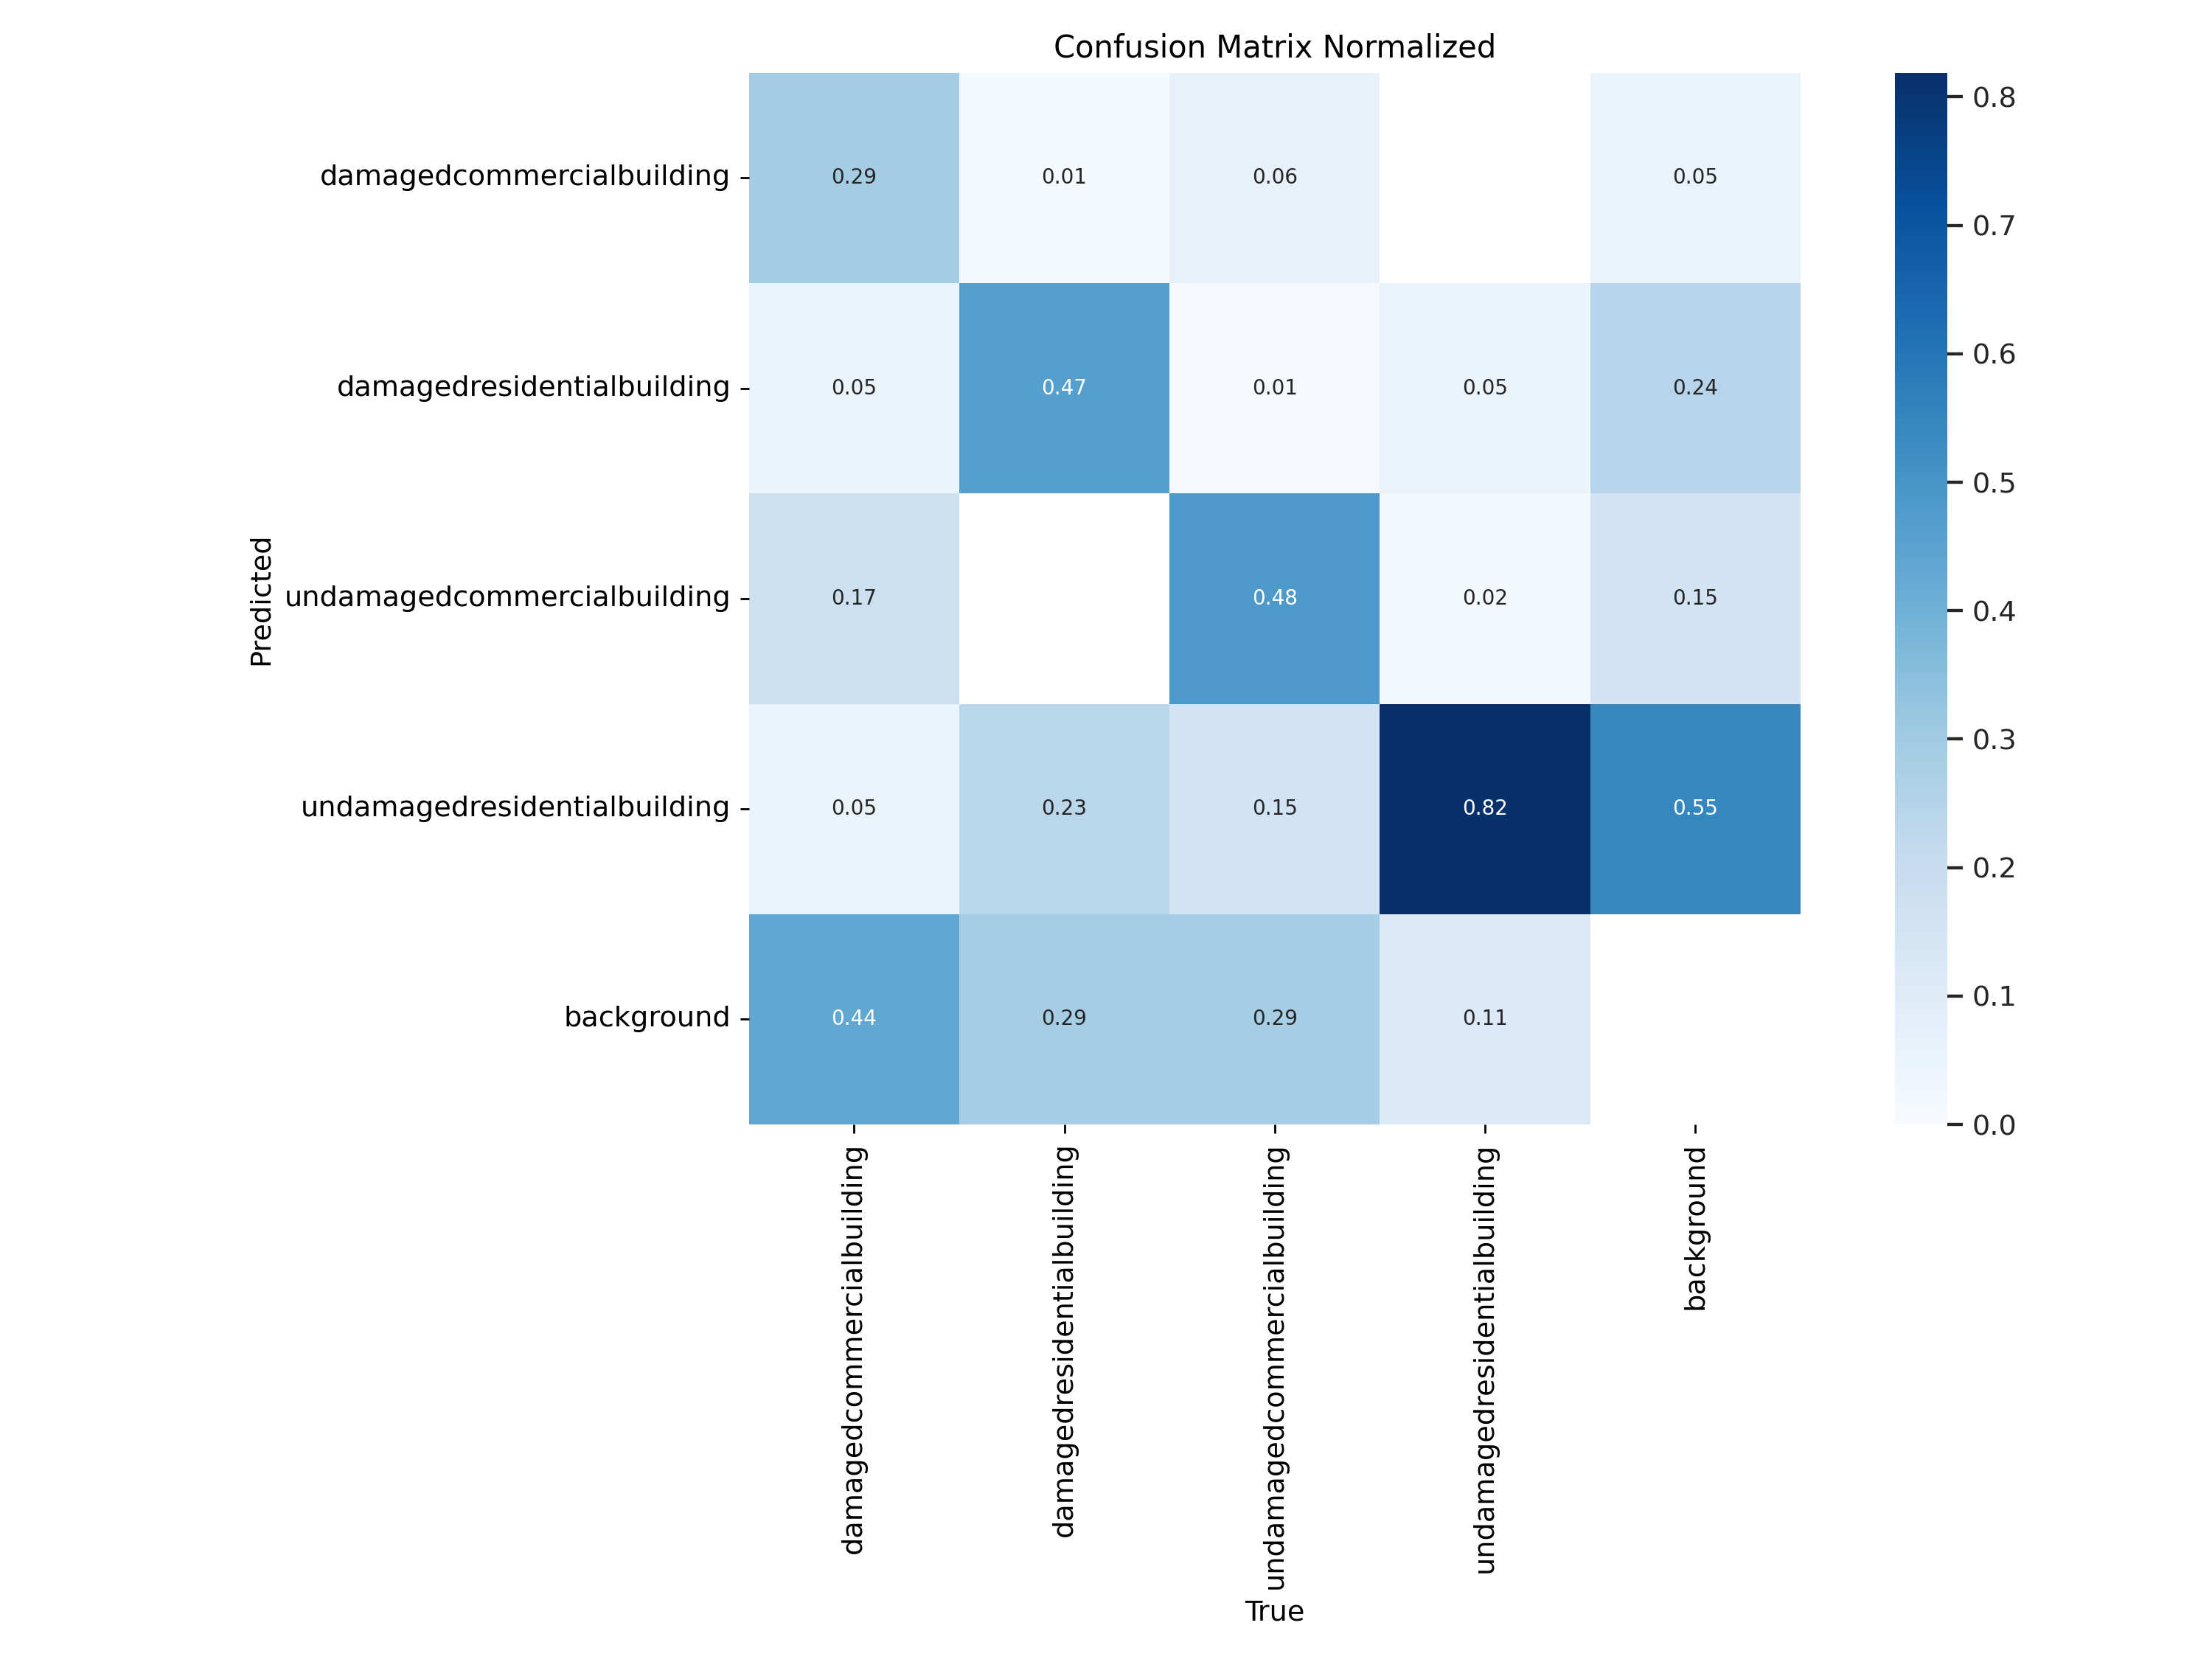

In [47]:
%cd {HOME}
Image(filename=f'{HOME}/{project}/{name_train}/confusion_matrix_normalized.png', width=600)

## Testing the model performance on Test dataset

Ultralytics YOLOv8 doesn't have a separate mode=test option built-in, as it focuses on training and validation (i.e., mode=train and mode=val).

That being said, if you wish to evaluate your model on a test dataset, you can indeed do so by treating your test data as validation data. After finalizing your model from the validation stage, you can run your model on the test dataset using the mode='val'.

To do this, make sure your test dataset is in the appropriate format expected by YOLOv8. You can simply replace your /val split with your /test data when you're ready to perform testing. This way, you can use the validation mode to evaluate how your model performs on unseen data!

In [36]:
# Load the model from the best training weights (Note: select path of the "best.pt" file)
path_to_weights_best = f"/content/{project_train}/yolo11n_training_dataset_v2/weights/best.pt"
model = YOLO(path_to_weights_best)

In [42]:
# Evaluate model metrics on the "test" dataset split
split_test = 'test'
name_metrics_test = f'metrics_{split_test}' # Directory name for saving results
metrics_test = model.val(data=yaml_file, imgsz=imgsz, batch=16, conf=0.25, iou=0.6, device=device, split=split_test, project=project, name=name_metrics_test)

Ultralytics 8.3.49 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)


val: Scanning /content/hurricanedamagev7-2/test/labels.cache... 1181 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1181/1181 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:30<00:00,  2.43it/s]


                   all       1181      22209      0.638      0.677      0.677      0.549
damagedcommercialbuilding        437        860      0.531      0.473      0.474      0.363
damagedresidentialbuilding        846       3687      0.594      0.664       0.65      0.511
undamagedcommercialbuilding        652       2367       0.62      0.657      0.666      0.553
undamagedresidentialbuilding        865      15295      0.807      0.914      0.919      0.767
Speed: 0.2ms preprocess, 4.3ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to exploratory_phase/metrics_test2


In [39]:
# Load the model from the best training weights
split_val = 'val'
name_metrics_val = f'metrics_{split_val}' # Directory name for saving results
# Run the selected model
metrics_val = model.val(data=yaml_file, imgsz=imgsz, batch=16, conf=0.25, iou=0.6, device=device, split=split_val, project=project, name=name_metrics_val)

Ultralytics 8.3.49 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)


val: Scanning /content/hurricanedamagev7-2/valid/labels.cache... 1181 images, 1 backgrounds, 0 corrupt: 100%|██████████| 1181/1181 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 74/74 [00:22<00:00,  3.33it/s]


                   all       1181      21053      0.617      0.667      0.659      0.533
damagedcommercialbuilding        463        893      0.473       0.43      0.422      0.317
damagedresidentialbuilding        871       3503      0.584      0.666      0.641      0.508
undamagedcommercialbuilding        665       2449       0.61      0.658      0.657       0.54
undamagedresidentialbuilding        892      14208      0.799      0.912      0.916      0.766
Speed: 0.3ms preprocess, 3.3ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to exploratory_phase/metrics_val


In [52]:
metrics_test.box.method

AttributeError: 'Metric' object has no attribute 'keys'. See valid attributes below.

    Class for computing evaluation metrics for YOLOv8 model.

    Attributes:
        p (list): Precision for each class. Shape: (nc,).
        r (list): Recall for each class. Shape: (nc,).
        f1 (list): F1 score for each class. Shape: (nc,).
        all_ap (list): AP scores for all classes and all IoU thresholds. Shape: (nc, 10).
        ap_class_index (list): Index of class for each AP score. Shape: (nc,).
        nc (int): Number of classes.

    Methods:
        ap50(): AP at IoU threshold of 0.5 for all classes. Returns: List of AP scores. Shape: (nc,) or [].
        ap(): AP at IoU thresholds from 0.5 to 0.95 for all classes. Returns: List of AP scores. Shape: (nc,) or [].
        mp(): Mean precision of all classes. Returns: Float.
        mr(): Mean recall of all classes. Returns: Float.
        map50(): Mean AP at IoU threshold of 0.5 for all classes. Returns: Float.
        map75(): Mean AP at IoU threshold of 0.75 for all classes. Returns: Float.
        map(): Mean AP at IoU thresholds from 0.5 to 0.95 for all classes. Returns: Float.
        mean_results(): Mean of results, returns mp, mr, map50, map.
        class_result(i): Class-aware result, returns p[i], r[i], ap50[i], ap[i].
        maps(): mAP of each class. Returns: Array of mAP scores, shape: (nc,).
        fitness(): Model fitness as a weighted combination of metrics. Returns: Float.
        update(results): Update metric attributes with new evaluation results.
    

In [43]:
print(f"The model \'{model_version}{model_variant}\' trained on dataset \'{dataset_name}-version{dataset_version}\'")
print(f"Below, comparison of evaluation metrics on dataset splits \'{split_test}\' and \'{split_val}\'")
print("--------------------------------------------------------------------------------")
print(f"Test dataset - mAP of each class: {metrics_test.box.maps}")
print(f"Val dataset - mAP of each class: {metrics_val.box.maps}")
print("--------------------------------------------------------------------------------")
print(f"Test dataset - Mean AP at IoU thresholds from 0.5 to 0.95 for all classes: {metrics_test.box.map}")
print(f"Val dataset - Mean AP at IoU thresholds from 0.5 to 0.95 for all classes: {metrics_val.box.map}")
print("--------------------------------------------------------------------------------")
print(f"Test dataset - Mean AP at IoU threshold of 0.5 for all classes: {metrics_test.box.map50}")
print(f"Val dataset - Mean AP at IoU threshold of 0.5 for all classes: {metrics_val.box.map50}")

The model '11n' trained on dataset 'hurricanedamagev7-version2'
Below, comparison of evaluation metrics on dataset splits 'test' and 'val'
--------------------------------------------------------------------------------
Test dataset - mAP of each class: [    0.36312     0.51072     0.55273      0.7675]
Val dataset - mAP of each class: [    0.31743     0.50813     0.53963     0.76638]
--------------------------------------------------------------------------------
Test dataset - Mean AP at IoU thresholds from 0.5 to 0.95 for all classes: 0.5485175007341675
Val dataset - Mean AP at IoU thresholds from 0.5 to 0.95 for all classes: 0.5328924112775228
--------------------------------------------------------------------------------
Test dataset - Mean AP at IoU threshold of 0.5 for all classes: 0.677158392877262
Val dataset - Mean AP at IoU threshold of 0.5 for all classes: 0.6591022881283402


## Downloading Results (.zip file)

In [24]:
from google.colab import files

# Define download parameters and file names
path_dir_to_zip = '/content/exploratory_phase/yolo11n_training_dataset_v2' #@param {type: "string"}
output_filename = 'yolo11n_training_dataset_v2.zip' #@param {type: "string"}
path_zip_file = f'{HOME}/{output_filename}'
delete_zip_file_after_download = "No"  #@param ['Yes', 'No']

os.system("zip -r {} {}".format(output_filename, path_dir_to_zip))
# Download file to local machine
files.download(output_filename)
# Delete the created zip file (optional)
if delete_zip_file_after_download == "Yes":
    os.system("rm -r {}".format(path_zip_file))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Draft Code (not important)

## Loading Training Datasets

Mound google drive which contains the required training dataset

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


Check internet speed (optional)

In [ ]:
!curl -s https://raw.githubusercontent.com/sivel/speedtest-cli/master/speedtest.py | python -

Retrieving speedtest.net configuration...
Testing from Google Cloud (34.126.168.143)...
Retrieving speedtest.net server list...
Selecting best server based on ping...
Hosted by PT. Jala Lintas Media (Semarang) [1171.81 km]: 30.175 ms
Testing download speed................................................................................
Download: 263.09 Mbit/s
Testing upload speed......................................................................................................
Upload: 184.19 Mbit/s


Print the current working directory in google collab

In [ ]:
!pwd

/content


Create a new directory for the dataset

In [ ]:
!mkdir data

In [ ]:
!cp -r ../gdrive/MyDrive/Colab\ Notebooks/datasets/hurricanedamagev7.v2i.yolov8.train.valid /content/data

Copy the whole directory with results to a connected google drive

In [ ]:
!scp -r /content/runs /content/gdrive/My Drive/ComputerVision/TrainingResults # adapt to own folder name